# 决策树

## 概述
决策树 $（Decision Tree）$ 属于有监督学习，有分类树也有决策树

节点分类
- 根节点：没有入度，只有出度
- 中间节点：既有出度也有入度，入度均为 $1$，出度不限
- 叶节点：没有出度，只有入度，入度均为 $1$。**每个叶节点都是一个类别标签**

两个相邻节点中，更靠近根节点的称为 **父节点**，另一个称为 **子节点**

可以把决策树看作一个 $if-then$ 规则的集合
- 由决策树根节点到叶节点的每一条路径构建一条规则
- 路径上中间节点的特征对应着规则的条件，叶节点的标签对应着规则的结论。

决策树的路径或者其对应的 $if-then$ 规则集合有一个重要的性质：互斥并且完备。也就是说，每一个实例都被 **有且仅有一条** 路径或者规则所覆盖。这里的覆盖指的是实例的特征与路径上的特征一致，或实例满足规则的条件。

## 构建决策树的准备工作
### 1、特征选择
特征选择就是决定用哪个特征来划分特征空间，其目的在于选取对训练数据具有分类能力的特征。这
样可以提高决策树学习的效率。如果利用一个特征进行分类的结果与随机分类的结果没有很大的差别，
则称这个特征是没有分类能力的，经验上扔掉这些特征对决策树学习的精度影响不会很大。

一般而言，随着划分过程不断进行，我们希望决策树的分支节点
所包含的样本尽可能属于同一类别，也就是节点的 **纯度** $（purity）$ 越来越高。

实际使用中，衡量的度量一般是 **不纯度**，度量不纯度的指标有：熵、增益率、基尼指数

#### 1.1、香农熵及其计算函数
熵定义为信息的期望值，概率统计中，一般表示随机变量不确定性的度量

假定当前样本集合 $D$ 中一共有 $n$ 类样本，第 $i$ 类样本为 $x_i$，则 $x_i$ 的信息定义为：
$$
l(x_i) = -\log_2p(x_i)
$$
其中 $p(x_i)$ 表示选择该分类的概率

通过上式，可以得到所有类别的信息。为了计算熵，需要计算所有类别的所有可能值包含的信息期望值（数学期望），通过以下公式得到
$$
Ent(D) = -\sum_{i=1}^n p(x_i) l(x_i)
$$
$Ent(D)$ 的值越小，$D$ 的不纯度越低

计算香农熵的 $python$ 代码如下：

In [1]:
def calEnt(dataSet):
    """计算香农熵

    Parameters
    ----------
    dataSet : 
        原始数据集
    """
    n = dataSet.shape[0] # 数据集行数
    labelSet = dataSet.iloc[:, -1].value_counts() # 标签所有类别
    p = labelSet / n # 每一类标签所占百分比
    ent = (-p*np.log2(p)).sum() # 计算信息熵
    return ent    

In [2]:
import numpy as np
import pandas as pd
# 构建数据集进行计算信息熵的测试
def createDataSet():
    row_data = {'no surfacing':[1,1,1,0,0],
                'flippers':[1,1,0,1,1],
                'fish':['yes','yes','no','no','no']}
    dataSet = pd.DataFrame(row_data)
    return dataSet

In [3]:
dataSet = createDataSet()
dataSet

,no surfacing,flippers,fish
0,1,1,yes
1,1,1,yes
2,1,0,no
3,0,1,no
4,0,1,no


In [4]:
calEnt(dataSet)

0.9709505944546686

熵越高，信息的不纯度就越高，也就是混合的数据就越多

#### 1.2、信息增益
信息增益 $（Information Gain）$ 的计算公式就是父节点的信息熵与其下所有总信息熵之差。要注意的是，此时计算子节点的总信息熵不能简单求和，而要求在求和汇总之前进行修正

假设离散属性 $a$ 有 $V$ 个可能的取值 ${a_1,a_2,\cdots ,a_v}$，若使用 $a$ 对样本数据集 $D$ 进行划分，则产生 $V$ 个分支节点，其中第 $v$ 个分支节点包含了 $D$ 中所有在属性 $a$ 上取值为 $a_v$ 的样本，记为 $D_v$。可根据信息熵的公式计算出 $D_v$ 的信息熵，再考虑到不同分支节点所包含的样本数不同，给分支节点赋予权重 $|D_v|/|D|$，这就是所谓的修正。

所以信息增益的计算公式为
$$
Gain(D,a) = Ent(D) - \sum_{i=1}^V \frac{|D_v|}{|D|} * Ent(D_v)
$$

则上面数据集中第 $0$ 列的信息增益为：

In [5]:
a=(3/5)*(-(2/3)*np.log2(2/3)-(1/3)*np.log2(1/3))
calEnt(dataSet)-a

0.4199730940219749

### 2、数据集最佳切分函数
划分数据集的最佳准则是选择 **最大信息增益**，也就是信息下降最快的方向。

In [6]:
def bestSplit(dataSet):
    """选择最佳分割特征和分割点
    
    Parameters
    ----------
    dataSet : 
        原始数据集
    return : 
        数据集最佳切分列的索引
    """
    baseEnt = calEnt(dataSet) # 计算原始熵
    bestGain = 0 # 初始化信息熵
    axis = -1 # 初始化最佳切分列（标签列）
    for i in range(dataSet.shape[-1] - 1): # 对特征的每一列进行遍历
        levels = dataSet.iloc[:, i].value_counts().index # 提取出当前列的所有取值
        ents = 0 # 初始化子节点的信息熵
        for j in levels: # 对当前列的每一个取值进行循环
            childSet = dataSet[dataSet.iloc[:, i] == j] # 某一个子节点的 dataFrame
            ent = calEnt(childSet) # 计算某一个子节点的信息熵
            ents += (childSet.shape[0]/dataSet.shape[0])*ent # 计算当前列的信息熵
        infoGain = baseEnt-ents # 计算当前列的信息增益
        # print(f'第{i}列的信息增益为{infoGain}')
        if (infoGain > bestGain):
            bestGain = infoGain # 更新最佳信息增益
            axis = i # 最大信息增益所在列的索引
    return axis

In [7]:
bestSplit(dataSet)

0

### 3、按照给定列切分数据集
通过最佳切分函数返回最佳切分列索引，就可以根据这个索引，构建一个按照给定列切分数据集的函数

In [8]:
def mySplit(dataSet, axis, value):
    """按照给定的列划分数据集

    Parameters
    ----------
    dataSet : 
        原始数据集
    axis : 
        指定的列索引
    value : 
        指定的属性值
    """
    col = dataSet.columns[axis]
    redataSet = dataSet.loc[dataSet[col] == value,:].drop(col,axis=1)
    return redataSet

验证函数，以 `axis = 0`, `vaule = 1`为例

In [9]:
mySplit(dataSet, 0, 1)

,flippers,fish
0,1,yes
1,1,yes
2,0,no


## 递归构建决策树
### *ID3* 算法
*ID3* 算法的核心是在决策树各个节点上对应信息增益准则选择特征，递归地构建决策树。具体方法是：从根节点开始，对节点计算所有可能的特征的信息增益，选择信息增益最大的特征作为节点的特征，由该特征的不同取值建立子节点；再对子节点递归地调用以上方法，构建决策树；知道所有特征的信息增益均很小或没有特征可以选择为止，最后得到一个决策树。

递归结束的条件是：程序遍历完所有的特征列，或者每个分支下的所有实例都具有相同分类。如果所有实例具有相同分类，则得到一个叶节点。任何到达叶节点的数据必然属于叶节点的分类，即叶节点里面必须是标签。

### 构建决策树的 *python* 代码

In [10]:
def createTree(dataSet):
    """基于最大信息增益切分数据集，递归构建决策树

    Parameters
    ----------
    dataSet : 
        原始数据集（最后一列是标签）

    Returns
    -------
    myTree :
        字典形式的树
    """    
    featlist = list(dataSet.columns) #提取出数据集所有的列
    classlist = dataSet.iloc[:,-1].value_counts() #获取最后一列类标签
    #判断最多标签数目是否等于数据集行数，或者数据集是否只有一列
    if classlist[0]==dataSet.shape[0] or dataSet.shape[1] == 1:
        return classlist.index[0] #如果是，返回类标签
    axis = bestSplit(dataSet) #确定出当前最佳切分列的索引
    bestfeat = featlist[axis] #获取该索引对应的特征
    myTree = {bestfeat:{}} #采用字典嵌套的方式存储树信息
    del featlist[axis] #删除当前特征
    valuelist = set(dataSet.iloc[:,axis]) #提取最佳切分列所有属性值
    for value in valuelist: #对每一个属性值递归建树
        myTree[bestfeat][value] = createTree(mySplit(dataSet,axis,value))
    return myTree

In [11]:
myTree = createTree(dataSet)
myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 决策树存储
使用 $numpy$ 中的 $save()$ 函数，将字典形式的数据直接保存成 $.npy$ 文件，需要调用时直接使用 $load()$ 函数即可。

In [12]:
np.save('myTree.npy',myTree)

In [13]:
read_myTree = np.load('myTree.npy', allow_pickle=True).item()
read_myTree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 使用决策树执行分类

In [14]:
def classify(inputTree,labels, testVec):
    """使用已构建的决策树对一个测试实例进行分类

    Parameters
    ----------
    inputTree : 
        已构建的决策树
    labels : 
        存储选择的最优特征标签
    testVec : 
        测试数据列表，顺序对应原始数据集

    Returns
    -------
    classLabel :
        分类结果
    """        
    firstStr = next(iter(inputTree)) #获取决策树第一个节点
    secondDict = inputTree[firstStr] #下一个字典
    featIndex = labels.index(firstStr) #第一个节点所在列的索引
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]) == dict :
                classLabel = classify(secondDict[key], labels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

注意：
- $python3$ 中 `myTree.keys()` 返回的是 `dict_keys` 类型而不是 `list` 类型，因此可以使用 `list(myTree.keys())[0]` 获取节点属性。

In [15]:
def acc_classify(train,test):
    """对测试集进行预测，并返回预测的结果

    Parameters
    ----------
    train : 
        训练集
    test : 
        测试集

    Returns
    -------
    test :
        完成分类的测试集
    """    
    inputTree = createTree(train) #根据测试集生成一棵树
    labels = list(train.columns) #数据集所有的列名称
    result = []
    for i in range(test.shape[0]): #对测试集中每一条数据进行循环
        testVec = test.iloc[i,:-1] #测试集中的一个实例
        classLabel = classify(inputTree,labels,testVec) #预测该实例的分类
        result.append(classLabel) #将分类结果追加到result列表中
    test['predict']=result #将预测结果追加到测试集最后一列
    acc = (test.iloc[:,-1]==test.iloc[:,-2]).mean() #计算准确率
    print(f'模型预测准确率为{acc}')
    return test

In [16]:
train = dataSet
test = dataSet.iloc[:3,:]
acc_classify(train,test)

模型预测准确率为1.0


C:\Users\11065\AppData\Local\Temp/ipykernel_27908/1597897043.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predict']=result #将预测结果追加到测试集最后一列


,no surfacing,flippers,fish,predict
0,1,1,yes,yes
1,1,1,yes,yes
2,1,0,no,no


使用 $SKlearn$ 中 $graphviz$ 包实现决策树的绘制

In [17]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz
#特征
Xtrain = dataSet.iloc[:,:-1]
#标签
Ytrain = dataSet.iloc[:,-1]
labels = Ytrain.unique().tolist()
Ytrain = Ytrain.apply(lambda x: labels.index(x)) #将本文转换为数字
#绘制树模型
clf = DecisionTreeClassifier()
clf = clf.fit(Xtrain, Ytrain)
tree.export_graphviz(clf)

# dot_data = tree.export_graphviz(clf, out_file=None)
# graphviz.Source(dot_data)

#给图形增加标签和颜色
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=['no surfacing', 'flippers'],
                                class_names=['fish', 'not fish'],
                                filled=True, rounded=True,
                                special_characters=True)
graphviz.Source(dot_data)
#利用render方法生成图形
graph = graphviz.Source(dot_data)
graph.render("fish")
graph


AttributeError: module 'graphviz' has no attribute 'Source'

## 决策树可视化
使用 `matplotlib` 中的注解工具 `annotation` 进行绘制
可视化需要使用的函数：
- `getNumLeafs`：获取决策树叶子节点的数目
- `getTreeDepth`：获取决策树深度
- `plotNode`：绘制节点
- `plotMidText`：绘制节点间的文本
- `plotTree`：绘制决策树
- `createPlot`：创建绘制面板（主函数）

### 1、计算叶子节点数目

In [ ]:
def getNumLeafs(myTree):
    """递归计算叶子节点个数

    Parameters
    ----------
    myTree : 
        字典形式的树

    Returns
    -------
    numLeafs :
        叶子节点个数
    """    
    numLeafs = 0 #初始化叶节点数目
    firstStr = next(iter(myTree)) #获得树的第一个键值，即第一个特征
    secondDict = myTree[firstStr] #获取下一组字典
    for key in secondDict.keys():
        if type(secondDict[key]) == dict: #测试该节点是否为字典
            numLeafs += getNumLeafs(secondDict[key]) #是字典，递归，循环计算新分支叶节点数
        else:
            numLeafs +=1 #不是字典，代表此结点为叶子结点
    return numLeafs

### 2、计算决策树的深度

In [ ]:
def getTreeDepth(myTree):
    """递归计算树的深度

    Parameters
    ----------
    myTree : 
        字典形式的树

    Returns
    -------
    maxDepth :
        树的最大深度
    """    
    maxDepth = 0
    firstStr = next(iter(myTree))
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]) == dict:
            thisDepth = 1+getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth>maxDepth:
            maxDepth = thisDepth
    return maxDepth

### 3、绘制节点

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文

In [ ]:
def plotNode(nodeTxt, cntrPt, parentPt, nodeType):
    """绘制节点

    Parameters
    ----------
    nodeTxt : 
        节点名
    cntrPt : 
        文本位置
    parentPt : 
        标注的箭头位置
    nodeType : 
        节点格式
    """    
    arrow_args = dict(arrowstyle="<-") #定义箭头格式
    createPlot.ax1.annotate(nodeTxt,
                            xy=parentPt,xycoords='axes fraction',
                            xytext=cntrPt, textcoords='axes fraction',
                            va="center", ha="center",
                            bbox=nodeType,
                            arrowprops=arrow_args)

### 4、标注有向边属性值

In [ ]:
def plotMidText(cntrPt, parentPt, txtString):
    """标注有向边属性值

    Parameters
    ----------
    cntrPt : 
        用于计算标注位置
    parentPt : 
        用于计算标注位置
    txtString : 
        标注的内容
    """    
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0] #计算标注位置的横坐标
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1] #计算标注位置的纵坐标
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center",
                        rotation=45)

### 5、绘制决策树
整体算法递归思路分三个步骤：
- 绘制自身
- 判断子节点非叶节点，递归
- 判断子节点为叶节点，绘制

In [ ]:
def plotTree(myTree, parentPt, nodeTxt):
    """绘制决策树

    Parameters
    ----------
    myTree : 
        字典形式的决策树
    parentPt : 
        标注的内容
    nodeTxt : 
        节点名
    """    
    decisionNode = dict(boxstyle="sawtooth", fc="0.8") #设置中间节点格式
    leafNode = dict(boxstyle="round4", fc="0.8") #设置叶节点格式
    numLeafs = getNumLeafs(myTree) #获取决策树叶结点数目，决定了树的宽度
    depth = getTreeDepth(myTree) #获取决策树层数
    firstStr = next(iter(myTree)) #下个字典
    cntrPt = (plotTree.xOff+
                    (1.0+float(numLeafs))/2.0/plotTree.totalW,plotTree.yOff)#确定中心位置
    plotMidText(cntrPt, parentPt, nodeTxt) #标注有向边属性值
    plotNode(firstStr, cntrPt, parentPt, decisionNode) #绘制节点
    secondDict = myTree[firstStr] #下一个字典，也就是继续绘制子结点
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD #y偏移
    for key in secondDict.keys():
        if type(secondDict[key])== dict: #测试该结点是否为字典
            plotTree(secondDict[key],cntrPt,str(key)) #是字典则不是叶结点，递归调用继续绘制
        else:
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW #x偏移
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

### 6、创建绘制面板

In [ ]:
def createPlot(inTree):
    """创建绘制面板

    Parameters
    ----------
    inTree : 
        字典形式的决策树
    """    
    fig = plt.figure(1, facecolor='white') #创建fig
    fig.clf() #清空fig
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops) #去掉x、y轴
    plotTree.totalW = float(getNumLeafs(inTree)) #获取决策树叶结点数目
    plotTree.totalD = float(getTreeDepth(inTree)) #获取决策树深度
    plotTree.xOff = -0.5/plotTree.totalW #x偏移
    plotTree.yOff = 1.0 #y偏移
    plotTree(inTree, (0.5,1.0), '') #绘制决策树
    plt.show()

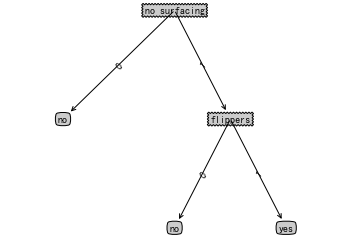

In [ ]:
createPlot(myTree)

## 算法总结
决策树优点;
- 能够可视化，容易理解和解释
- 数据准备工作少。（其他算法通常需要数据规范化，需要创建虚拟变量并删除空值等）
- 能够哦同时处理数值和分类数据，既可以做回归也可以做分类
- 效率高，决策树只需要进行一次构建，反复使用，每一次预测的最大计算次数不超过决策树的最大深度
- 能够处理多输出问题，即含有多个标签的问题
- 是一个白盒模型，结果能够很容易被解释。如果在模型中能够观察到给定情况，则可以通过布尔逻辑轻松解释条件。相反，在黑盒模型中（例如人工神经网络），结果可能难以解释

决策树缺点：
- 递归生成树的方法容易造成过拟合
- 决策树可能是不稳定的，因为即使非常小的差异，也可能产生一棵完全不同的树
- 如果某些分类占优势，决策树将会创建一棵有偏差的树。因此，建议在拟合决策树之前平衡数据集